# Create TL from Green's functions
This code builds TL curves from seismic Green's functions for a range of sources and subsurface models

## Load Green's functions from pyrocko

In [14]:
%matplotlib notebook
import os

from pyrocko.gf import LocalEngine, Target, DCSource, ws
from pyrocko import trace
from pyrocko.gui.marker import PhaseMarker
from pyrocko import gf
from obspy.core.utcdatetime import UTCDateTime
import obspy 
import pandas as pd

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pyrocko import moment_tensor as pmt
from obspy.geodetics import kilometers2degrees
from scipy.interpolate import RectBivariateSpline


def build_amps_and_traces(dists, depths, base_folder, store_id, stf=None):

    engine = gf.LocalEngine(store_dirs=[f'{base_folder}{store_id}/'])
    store = engine.get_store(store_id)
    
    waveform_targets = [
            gf.Target(
               quantity='velocity',
               lat=0., lon=lon,
               store_id=store_id,
               interpolation='multilinear',
               codes=('NET', 'STA', 'LOC', 'Z'))
            for lon in dists
            ]

    all_amps_RW, all_amps_S = [], []
    factor = 1.
    for depth in depths:

        # Let's use a double couple source representation.
        
        #factor = 1e20
        stf_add = {}
        if stf is not None:
            stf_add['stf'] = stf
        mt_source = gf.MTSource(
           lat=0., lon=0., depth=depth,
           mnn=0.*factor, mee=-1.*factor, mdd=1.*factor, mne=0.*factor, mnd=0.*factor, med=0.*factor,**stf_add)

        # The computation is performed by calling process on the engine
        response = engine.process(mt_source, waveform_targets)

        # convert results in response to Pyrocko traces
        synthetic_traces = response.pyrocko_traces()

        amps_RW = []
        amps_S = []
        for t, waveform in zip(waveform_targets, synthetic_traces):
            dist = t.distance_to(mt_source)
            depth = mt_source.depth
            #print(dist, depth)
            t_s = store.t('s', (depth, dist))
            t_S = store.t('S', (depth, dist))
            arrival_time = t_s
            if (t_s is None):
                arrival_time = t_S
            elif t_S is not None:
                arrival_time = min(t_S, t_s)
            if (t_S is None):
                arrival_time = t_s

            if arrival_time is None:
                v_RW = (1./0.95)*dist/waveform.get_xdata()[waveform.get_ydata().argmax()]
                t_RW = dist/v_RW
                arrival_time = t_RW-20.
            else:
                arrival_time += 10.

            amps_RW.append(abs(waveform.get_ydata()).max())
            iS = np.argmin(abs(waveform.get_xdata()-(arrival_time)))
            amps_S.append(abs(waveform.get_ydata())[:iS].max())

        all_amps_RW.append(amps_RW)
        all_amps_S.append(amps_S)

    all_amps_RW = np.array(all_amps_RW)
    all_amps_S = np.array(all_amps_S)
    
    return all_amps_RW, all_amps_S, waveform_targets, synthetic_traces

## Discretization
dists = np.arange(1., 90., 1)[:] # in degrees
depths = np.linspace(5e3, 30e3, 50)
#dists = np.arange(1., 10., 2.5)[:] # in degrees
#depths = np.linspace(10e3, 30e3, 2)
#dists = np.arange(kilometers2degrees(10), kilometers2degrees(1900),  kilometers2degrees(100))[-7:-1]

## STF
period = 1.
stf = gf.BoxcarSTF(period, anchor=0.)
stf = None

## Greens functions STORES
base_folder = '/projects/infrasound/data/infrasound/2023_Venus_inversion/'
stores_id = []
stores_id.append('GF_venus')
stores_id.append('GF_venus_c30km')
#stores_id.append('ak135_2000km_1Hz')
#stores_id.append('GF_venus_small')
#stores_id.append('GF_venus_small_c30km')
#stores_id.append('GF_venus_small_morevariations')

waveform_targets_all, synthetic_traces_all = [], []
for istore, store_id in enumerate(stores_id):
    all_amps_RW, all_amps_S, waveform_targets, synthetic_traces = build_amps_and_traces(dists, depths, base_folder, store_id, stf=None)
    waveform_targets_all.append(waveform_targets)
    synthetic_traces_all.append(synthetic_traces)
    
    if istore == 0:
        all_amps_RW_all = all_amps_RW
        all_amps_S_all = all_amps_S
    else:
        all_amps_RW_all = np.r_[all_amps_RW_all, all_amps_RW]
        all_amps_S_all = np.r_[all_amps_S_all, all_amps_S]

## Visualization of Green's functions

<IPython.core.display.Javascript object>


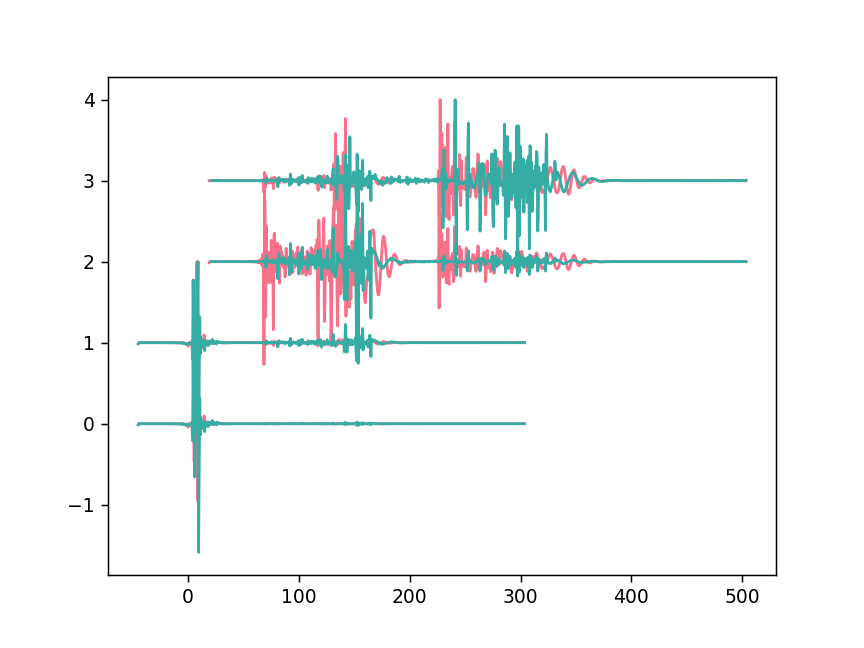

<IPython.core.display.Javascript object>


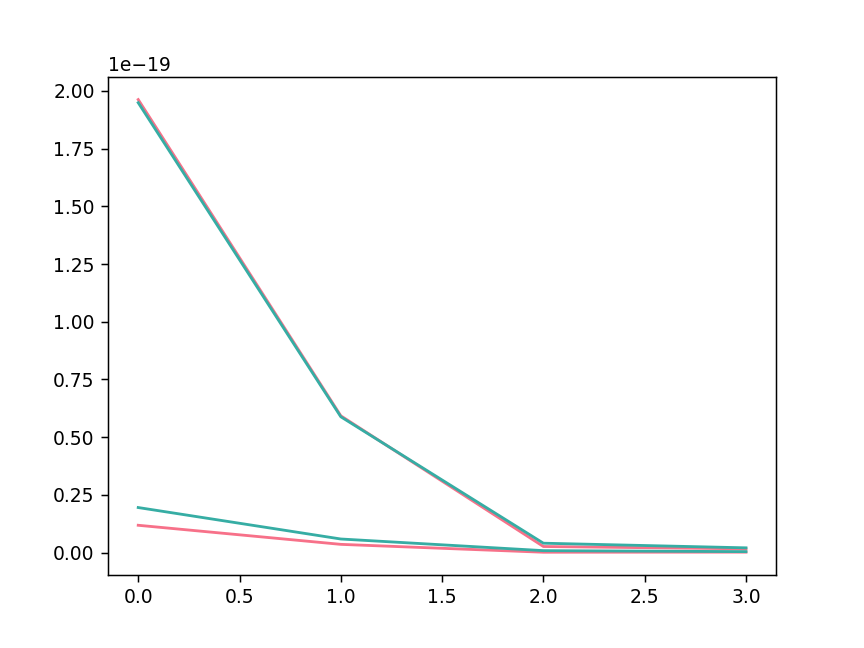

In [39]:
import seaborn as sns
colors = sns.color_palette("husl", len(waveform_targets_all))

plt.figure()
plot_arrivals = False
istore = -1
for waveform_targets, synthetic_traces in zip(waveform_targets_all, synthetic_traces_all):
    iwaveform = -1
    istore += 1
    for t, waveform in zip(waveform_targets, synthetic_traces):
        iwaveform += 1
        plt.plot(waveform.get_xdata(), waveform.get_ydata()/waveform.get_ydata().max()+iwaveform, zorder=1, color=colors[istore])

        if plot_arrivals:
            dist = t.distance_to(mt_source)
            depth = mt_source.depth
            #print(dist, depth)
            arrival_time_P = store.t('P', (depth, dist))-10.
            arrival_time_P_end = arrival_time_P+20.
            arrival_time_S = store.t('S', (depth, dist))-10.
            arrival_time_S_end = arrival_time_S+20.
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_P))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_P_end))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_S))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            it = np.argmin(abs(waveform.get_xdata()-arrival_time_S_end))
            plt.scatter(waveform.get_xdata()[it], iwaveform, marker='|', color='black', s=50, zorder=10)
            
plt.figure()
istore = -1
for all_amps_RW, all_amps_S in zip(all_amps_RW_all, all_amps_S_all):
    istore += 1
    plt.plot(all_amps_RW.T, color=colors[istore])

## Extraction of median/quantiles, extrapolation to global scale (>10000 km), writes to file

<IPython.core.display.Javascript object>


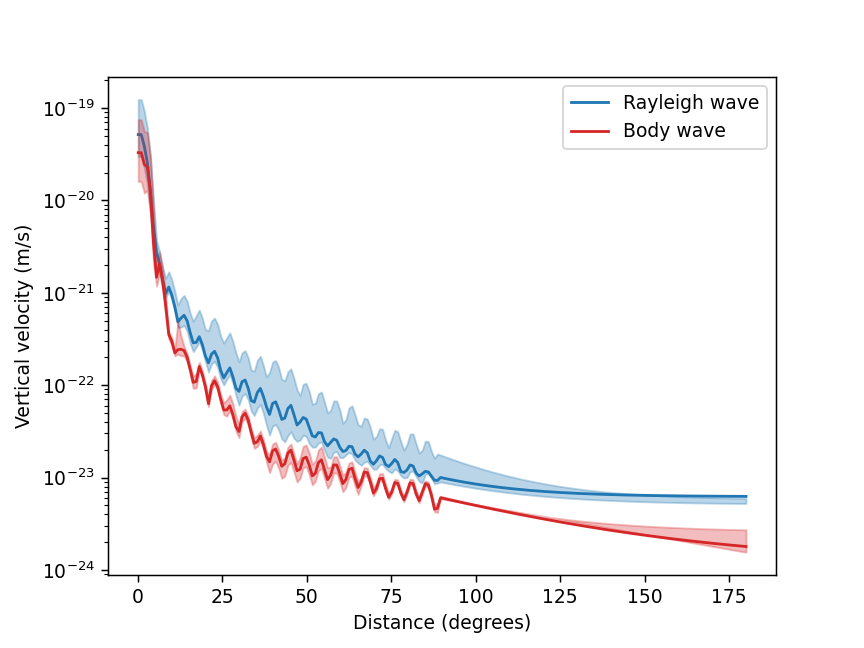

In [57]:
from scipy import interpolate, stats
from scipy.optimize import curve_fit

def fit_TL_global(x, a, b, c):
    return a * np.exp(-b * x) + c
    
def get_git_params(dists, amps, factor, dist_lim, bounds=[0.1, 0.1, 1e2]):
    
    #factor = 1e20
    #dist_lim = 30
    popt, pcov = curve_fit(fit_TL_global, dists[dists>dist_lim], factor*amps[dists>dist_lim], bounds=(0, bounds))
    return popt
    
def construct_one_TL_global(dists, amps, factor, dist_lim):
    
    #amps = np.quantile(all_amps_RW, q=q, axis=0)
    f = interpolate.interp1d(dists, amps, bounds_error=False, fill_value=(amps[0], amps[-1]))
    popt = get_git_params(dists, amps, factor, dist_lim, bounds=[0.1, 0.1, 1e2])
    f_global = lambda dist: fit_TL_global(dist, *popt)/factor
    dist_max = dists.max()
    TL_q = lambda dist: np.where(dist<dist_max, f(dist), f_global(dist))
    return TL_q

def build_median_qmin_qmax(dists, all_amps_RW, all_amps_S, qs=[0.25, 0.75], dist_lim=30., dist_lim_body=49., factor=1e20):

    #dists = np.arange(1., 80., 1)[:] # in degrees
    amps = np.median(all_amps_RW, axis=0)
    f_median = construct_one_TL_global(dists, amps, factor, dist_lim)
    f_qs = []
    for q in qs:
        amps = np.quantile(all_amps_RW, q=q, axis=0)
        f_qs.append( construct_one_TL_global(dists, amps, factor, dist_lim) )
    
    amps = np.median(all_amps_S, axis=0)
    f_median_body = construct_one_TL_global(dists, amps, factor, dist_lim_body)
    f_qs_body = []
    for q in qs:
        amps = np.quantile(all_amps_S, q=q, axis=0)
        f_qs_body.append( construct_one_TL_global(dists, amps, factor, dist_lim_body) )
    
    """
    coords = np.c_[np.tile(dists[:,np.newaxis], all_amps_RW.shape[0]).T.ravel(), all_amps_RW.ravel()]
    coords = np.c_[np.tile(dists[:,np.newaxis], all_amps_S.shape[0]).T.ravel(), all_amps_S.ravel()]
    ids = np.tile(np.arange(all_amps_RW.shape[0])[:,np.newaxis], dists.size).ravel()
    kernel = stats.gaussian_kde(coords.T)
    amps = np.linspace(all_amps_RW.min(), all_amps_RW.max(), 100)
    amps = np.linspace(all_amps_S.min(), all_amps_S.max(), 100)
    DISTS, AMPS = np.meshgrid(dists_new, amps)
    shape_init = DISTS.shape
    DISTS, AMPS = DISTS.ravel(), AMPS.ravel()
    density = kernel(np.c_[DISTS, AMPS].T)
    density = density.reshape(shape_init)
    """
    
    return f_median, f_qs, f_median_body, f_qs_body

def write_tofile(file, dists_new, f_median, f_qs, f_median_body, f_qs_body, qs):
    array = np.c_[dists_new, 
                  f_median(dists_new),
                  f_qs[0](dists_new),
                  f_qs[1](dists_new), 
                  f_median_body(dists_new),
                  f_qs_body[0](dists_new),
                  f_qs_body[1](dists_new), ]
    columns = ['dist',
               'median_rw',
               f'median_q{qs[0]}_rw',
               f'median_q{qs[1]}_rw',
               'median_body',
               f'median_q{qs[0]}_body',
               f'median_q{qs[1]}_body',]
    TLs = pd.DataFrame(array, columns=columns)
    TLs.to_csv(file, header=True, index=False)
    return TLs
    
dist_lim=50.
dist_lim_body=50.
factor=1e20
dists_new = np.linspace(0.1, 180., 200)
qs=[0.25, 0.75]
file = './test_data_Venus/GF_reverse_fault_1Hz.csv'
f_median, f_qs, f_median_body, f_qs_body = build_median_qmin_qmax(dists, all_amps_RW, all_amps_S, qs=qs, dist_lim=dist_lim, dist_lim_body=dist_lim_body, factor=factor)

TLs = write_tofile(file, dists_new, f_median, f_qs, f_median_body, f_qs_body, qs)
    
plt.figure()
plt.plot(dists_new, f_median(dists_new), color='tab:blue', zorder=10, label='Rayleigh wave')
plt.fill_between(dists_new, f_qs[0](dists_new), f_qs[1](dists_new), color='tab:blue', alpha=0.3, zorder=10)
plt.plot(dists_new, f_median_body(dists_new), color='tab:red', zorder=10, label='Body wave')
plt.fill_between(dists_new, f_qs_body[0](dists_new), f_qs_body[1](dists_new), color='tab:red', alpha=0.3, zorder=10)

plt.xlabel('Distance (degrees)')
plt.ylabel('Vertical velocity (m/s)')
plt.yscale('log')
plt.legend()
#plt.ylim([factor*1e-24, factor*1e-19])